MeanShift 추적 실습

- 색상기반 객체 추적
- 비슷한 색상 가진 영역 자동으로 따라가기
- 색상분포(히스토그램)를 기반 객체 추적
- 확률이 높은 방향으로 윈도우 이동 >> 최적 위치(x,y) 찾기
- 실시간 추적에 적합(아주 빠름)

In [15]:
import numpy as np
import cv2
# from google.colab.patches import cv2_imshow # Colab 환경에서 이미지 표시를 위한 함수 임포트
import time # 출력 속도 조절을 위한 time 모듈 임포트
import matplotlib.pyplot as plt

# --- 1. 변수 초기 설정 ---
roi_hist = None # 추적 대상 객체의 정규화된 히스토그램 저장 변수 (초기값: None)
# roi(region of interest 관심 영역) histogram 변수
win_name = 'MeanShift Tracking' # 화면 표시 창 이름 (Colab에서는 디버깅용)

# MeanShift/CamShift 중지 요건 (Termination Criteria)
# (오차(EPS) 또는 반복 횟수(COUNT) 중 하나라도 충족되면 중지)
# 최대 반복 횟수: 10, 허용 오차: 1.0
termination = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1)
# 최대 10번 반복 하거나 이동거리가 1픽셀 미만이면 수렴 (이 중 하나만 만족해도 종료)

# 추적 대상 영역 (바운딩 박스) 좌표를 저장할 전역 변수
# Colab에서는 cv2.selectROI를 사용할 수 없으므로, 초기 값을 하드코딩합니다.
# NOTE: 이 값을 수정하여 추적할 객체의 초기 위치와 크기를 설정할 수 있습니다.
# (x, y) = 시작 좌표, (w, h) = 너비, 높이
x, y, w, h = 500, 300, 150, 100

In [16]:
# --- 2. 비디오 캡처 설정 ---
# NOTE: Colab에서 이 코드를 실행하기 전에, 'newyork.mp4' 파일을 Colab 환경에 업로드해야 합니다.
video_path = '/home/kim/Desktop/AI_cours/data/newyork.mp4' # 처리할 비디오 파일 경로
cap = cv2.VideoCapture(video_path) # 비디오 캡처 객체 생성
delay = int(1000/24) # 딜레이 설정 (약 41ms)

# 비디오 파일이 제대로 열렸는지 확인
if not cap.isOpened():
    print("오류: 비디오 파일을 열 수 없습니다. 파일을 업로드했는지 확인하세요.")
    exit()

# Colab 환경을 위해 프레임 처리 개수를 제한하고 출력 주기를 설정합니다.
frame_count = 0
MAX_FRAMES_TO_PROCESS = 150 # 최대 150 프레임만 처리
DISPLAY_EVERY_N_FRAMES = 20 # 20 프레임마다 결과 출력

print(f"MeanShift 추적 시작 (최대 {MAX_FRAMES_TO_PROCESS} 프레임, {DISPLAY_EVERY_N_FRAMES} 프레임마다 출력)...")

MeanShift 추적 시작 (최대 150 프레임, 20 프레임마다 출력)...


In [17]:
# --- 3. 첫 프레임에서 ROI 히스토그램 등록 ---
ret, frame = cap.read()
if not ret:
    print("오류: 첫 프레임을 읽을 수 없습니다.")
    exit()

# 1. 초기 추적 대상 영역(ROI) 추출
roi = frame[y:y + h, x:x + w]
# frame[100:200, 100:250]
# frame[세로길이, 가로길이] >> frame[100, 150] >> 100*150 크기 이미지

# 2. ROI를 HSV 컬러로 변경
roi_hsv = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)

# 3. ROI의 H(색상) 채널에 대한 히스토그램 계산

roi_hist = cv2.calcHist([roi_hsv], [0], None, [180], [0, 180])
# [roi_hsv] : HSV 형태로 변환한 입력 이미지 >> [] 리스트로 전달
# [0] : H 채널만 사용 (0번 채널)
# [180]: bin 개수 (히스토그램 구간 개수) 180개 bin
#  None  마스크 >> 전체 사용
# [0, 180]: H 채널 범위 (0도~180도)

# 4. 히스토그램 정규화 (최소 0, 최대 255)
cv2.normalize(roi_hist, roi_hist, 0, 255, cv2.NORM_MINMAX)
# roi_hist(first) : 입력 데이터 (ROI 영역 색상 히스토그램-색 분포 데이터)
# roi_hist(second) 변환된 결과 덮어쓰기(정규화된 결과 > 기존 배열에 직접 수정)

print(f"초기 추적 대상 영역 설정 완료: (x={x}, y={y}, w={w}, h={h})")

초기 추적 대상 영역 설정 완료: (x=500, y=300, w=150, h=100)


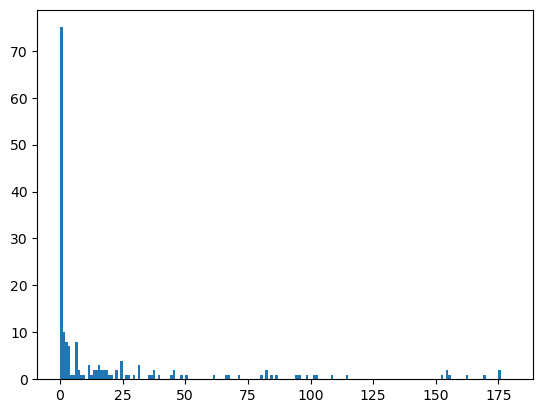

In [20]:
plt.hist(roi_hist.ravel(), bins=180, range=[0,180])
roi_hist.shape
plt.show()

역투영 (BACK-PROJECTION)(***)
-  이 픽셀이 가진 색상이 내가 찾는 색상일 확률은?

- 그럼 어떻게 하나?
  - 현재 픽셀의 h(hue) 값 확인 (예: 30도)
  - ROI(관심영역) 히스토그램에서 30도가 얼마나 나오는지(빈도) 확인
  - 그 빈도를 픽셀값으로 설정
  - 그 결과, 밝을 수록 유사한 색상이다라고 간주

In [22]:
roi_hist.shape

(180, 1)

In [24]:
frame.shape

(1080, 1920, 3)

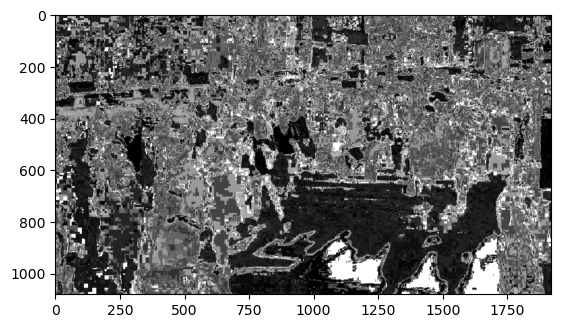

In [ ]:
# plt.imshow(dst,cmap='gray')

In [ ]:
# --- 4. 비디오 처리 루프 ---
while cap.isOpened() and frame_count < MAX_FRAMES_TO_PROCESS:
    ret, frame = cap.read()
    if not ret:
        break

    img_draw = frame.copy() # 원본 프레임에 추적 결과를 그리기 위해 복사

    # 전체 영상 BGR -> HSV 컬러 변환
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

    # 전체 영상에 대해 ROI 히스토그램을 역투영(Back Projection) (***)
    # dst는 각 픽셀이 ROI 색상과 얼마나 유사한지 나타내는 확률 맵이 됨. (0~255)
    # [0]: H(색상) 채널 사용, [0, 180]: H 채널의 범위
    # 1: scale
    dst = cv2.calcBackProject([hsv], [0], roi_hist, [0, 180], 1) # 각 부분이 비슷한 정도를 수치로 나타냄

    # 역투영 결과(dst)와 이전 추적 위치로 평균 이동(Mean Shift) 추적 실행
    # ret: 반복 횟수, (x, y, w, h): 새로운 추적 위치
    ret, (x, y, w, h) = cv2.meanShift(dst, (x, y, w, h), termination)

    # 새로운 위치에 초록색 사각형 표시
    cv2.rectangle(img_draw, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # 컬러 영상(추적 결과)과 역투영 영상(dst)을 좌우로 통합하여 출력
    # dst는 GRAY이므로 cv2.cvtColor()로 BGR 변환하여 합침
    result = np.hstack((img_draw, cv2.cvtColor(dst, cv2.COLOR_GRAY2BGR)))


    # Colab 출력: 특정 간격의 프레임만 표시
    if frame_count % DISPLAY_EVERY_N_FRAMES == 0:
        print(f"\n--- Frame {frame_count} MeanShift 추적 결과 ---")
        cv2.imshow(win_name,result) # 추적 결과 프레임 표시
        key = cv2.waitKey(1000) & 0xff
        if key == 27:            # ESC 키: 종료
            break
        time.sleep(1) # 출력이 빠르게 지나가는 것을 방지하기 위해 잠시 대기

    # 키 입력 처리 (원본 코드에 있던 부분. Colab에서는 작동하지 않으므로,
    # 프레임 수 제한으로 대체하며 주석 처리만 해둡니다.)
    # key = cv2.waitKey(delay) & 0xff
    # if key == 27:            # ESC 키: 종료
    #     break
    # elif key == ord(' '):    # 스페이스바: ROI 설정 (Colab에서는 불가능)
    #     ...

    frame_count += 1

# --- 5. 종료 및 정리 ---
print("\n비디오 처리 완료 및 정리.")
cap.release()
# 모든 OpenCV 창 닫기 (Colab에서는 필요 없음)
cv2.destroyAllWindows()


--- Frame 0 MeanShift 추적 결과 ---

--- Frame 20 MeanShift 추적 결과 ---

--- Frame 40 MeanShift 추적 결과 ---

--- Frame 60 MeanShift 추적 결과 ---

--- Frame 80 MeanShift 추적 결과 ---

--- Frame 100 MeanShift 추적 결과 ---

--- Frame 120 MeanShift 추적 결과 ---

--- Frame 140 MeanShift 추적 결과 ---

비디오 처리 완료 및 정리.
